# <center> Anomaly Detection from timeseries data</center>


---


*   Mohammad POUL DOUST
*   Andrei MARDALE
*   Etienne EKPO
*   Laetitia COUGE



# Installs and Imports

In [0]:
!pip3 install metric-learn
!pip3 install pot

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 307kB 4.7MB/s 


In [0]:
import pandas as pd
import numpy as np

import h5py

from scipy.special import expit
from scipy.spatial import distance

import pywt
import scipy

from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.decomposition.pca import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold.t_sne import TSNE
from sklearn.cluster import DBSCAN

from metric_learn import LMNN

from sklearn.model_selection import train_test_split
import seaborn as sns

%tensorflow_version 1.x
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, Reshape, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, optimizers

import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Acquisition

In [0]:
!wget 'https://defi-ia.insa-toulouse.fr/static/data/train.hdf5' --no-check-certificate
!wget 'https://defi-ia.insa-toulouse.fr/static/data/validation.hdf5' --no-check-certificate
!wget 'https://defi-ia.insa-toulouse.fr/static/data/test.hdf5' --no-check-certificate

--2020-01-14 20:20:27--  https://defi-ia.insa-toulouse.fr/static/data/train.hdf5
Resolving defi-ia.insa-toulouse.fr (defi-ia.insa-toulouse.fr)... 195.83.9.100
Connecting to defi-ia.insa-toulouse.fr (defi-ia.insa-toulouse.fr)|195.83.9.100|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 825280760 (787M) [application/octet-stream]
Saving to: ‘train.hdf5’

train.hdf5          100%[===================>] 787.05M  19.2MB/s    in 42s     

2020-01-14 20:21:10 (18.6 MB/s) - ‘train.hdf5’ saved [825280760/825280760]

--2020-01-14 20:21:11--  https://defi-ia.insa-toulouse.fr/static/data/validation.hdf5
Resolving defi-ia.insa-toulouse.fr (defi-ia.insa-toulouse.fr)... 195.83.9.100
Connecting to defi-ia.insa-toulouse.fr (defi-ia.insa-toulouse.fr)|195.83.9.100|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 292955936 (279M) [application/octet-stream]

# Auxiliary Functions

In [0]:
def load_dataset(train_path, valid_path, test_path):
    with h5py.File(train_path, 'r') as f:
        a_group_key = list(f.keys())[0]
        group = f[a_group_key]
        
        data = group["block0_values"][()]
        train_data = data
    
    with h5py.File(valid_path, 'r') as f:
        a_group_key = list(f.keys())[0]
        group = f[a_group_key]
        
        data = group["block0_values"][()]
        valid_data = data
        
    with h5py.File(test_path, 'r') as f:
        a_group_key = list(f.keys())[0]
        group = f[a_group_key]
        
        data = group["block0_values"][()]
        test_data = data
    
    return train_data, valid_data, test_data
  


def split_without_overlap(X, size=50):
  r = []
  for i in range(X.shape[0]):
    
    r.append(X[i].reshape(-1, size, 1))
    
  return r

def filter_training(X_train):
  col = np.load('filtered_training.npy')
  X_train = X_train[col == 1]
  
  return X_train

def aggregate_by_mean(X_train, X_valid, X_test):
    X_train_agg = np.mean(X_train.reshape((X_train.shape[0], 12288, 5)), axis = 2)
    X_valid_agg = np.mean(X_valid.reshape((X_valid.shape[0], 12288, 5)), axis = 2)
    X_test_agg = np.mean(X_test.reshape((X_test.shape[0], 12288, 5)), axis = 2)
  
    return X_train_agg, X_valid_agg, X_test_agg

        
def _write_output_file(content, filename='output.csv'):
    if type(content) is list:
        str_content = ""
        for i in range(0,len(content)):
            str_content +="{};{}\n".format(i,content[i])
        content = str_content
            
        
    header = str.format("{};{}\n","seqID" ,"anomaly")
    content = header+content
    
    with open(filename, "w+") as fh:
        fh.write(content)

def plot_sequence(sequence):
    plt.figure(figsize=(20,5))
    plt.plot(sequence)
    plt.show()

# Data Loading

In [0]:
X_train, X_validation, X_test  = load_dataset('train.hdf5', 'validation.hdf5', 'test.hdf5')

# Part 1: Easy anomalies using Auto-Encoder or OC-SVM

## Data Preprocessing

In [0]:
# Apply sigmoid on the signal
X_train_ = expit(X_train)
X_validation_ = expit(X_validation)
X_test_ = expit(X_test)

In [0]:
X_train_ = filter_training(X_train_)

In [0]:
# Split without overlapping
X_train_list = split_without_overlap(X_train_, 384)
X_valid_list = split_without_overlap(X_validation_, 384)
X_test_list = split_without_overlap(X_test_, 384)

In [0]:
print(len(X_train_list))
print(X_train_list[0].shape)

print(len(X_valid_list))
print(X_valid_list[0].shape)

print(len(X_test_list))
print(X_test_list[0].shape)

1300
(160, 384, 1)
594
(160, 384, 1)
1917
(160, 384, 1)


## Conv1D Autoencoder Training


In [0]:
epochs = 10
batch_size = X_train_list[0].shape[0]
input_dim = X_train_list[0].shape[1] #num of predictor variables, 
lr = 0.0001

input_window = Input(shape=(input_dim, 1))
x = Conv1D(64, 128, activation='relu', padding="same")(input_window) # 384 dims
x = MaxPooling1D(2, padding="same")(x) # 192 dims
encoded = Conv1D(32, 48, activation='relu', padding="same")(x) #192 dims

encoder = Model(input_window, encoded)

x = Conv1D(32, 48, activation='relu',  padding="same")(encoded) # 192 dims
x = UpSampling1D(2)(x) # 384 dims
decoded = Conv1D(1, 128, activation='sigmoid', padding='same')(x) # 384 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 384, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 384, 64)           8256      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 192, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 192, 32)           98336     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 192, 32)           49184     
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 384, 32)           0         
____________________________________________

In [0]:
adam = optimizers.Adam(lr)
autoencoder.compile(loss='binary_crossentropy', optimizer=adam)

i = 0
for xx in X_train_list:
  print(i)
  i+=1
  autoencoder.fit(xx, xx,
                epochs=epochs,
                batch_size=batch_size,
                verbose = 0)

## Apply the auto-encoder on the training data.

In [0]:
mses = []
i = 0
for xx in X_train_list:
  print(i)
  i+=1
  pred = autoencoder.predict(xx).reshape(xx.shape[0]*xx.shape[1],)
  xx_valid = xx.reshape(xx.shape[0]*xx.shape[1],)
  mses.append(distance.euclidean(xx_valid, pred))

(0.0, 30)

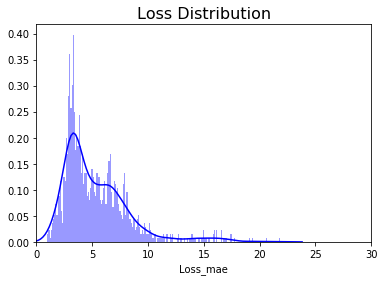

In [0]:
scored = pd.DataFrame()
scored['Loss_mae'] = mses
plt.figure()
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 200, kde= True, color = 'blue');
plt.xlim([0.0,30])


## Apply the autoencoder on the validation set

In [0]:
mses_valid = []
i = 0
for xx in X_valid_list:
  print(i)
  i+=1
  pred = autoencoder.predict(xx).reshape(xx.shape[0]*xx.shape[1],)
  xx_valid = xx.reshape(xx.shape[0]*xx.shape[1],)
  mses_valid.append(distance.euclidean(xx_valid, pred))
  


(0.0, 150)

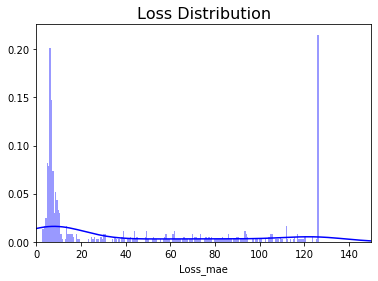

In [0]:
scored = pd.DataFrame()
scored['Loss_mae'] = mses_valid
plt.figure()
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 200, kde= True, color = 'blue');
plt.xlim([0.0,150])

## Apply the AE on the test set

In [0]:
mses_test = []
i = 0
for xx in X_test_list:
  print(i)
  i+=1
  pred = autoencoder.predict(xx).reshape(xx.shape[0]*xx.shape[1],)
  xx_test = xx.reshape(xx.shape[0]*xx.shape[1],)
  mses_test.append(distance.euclidean(xx_test, pred))

(0.0, 150)

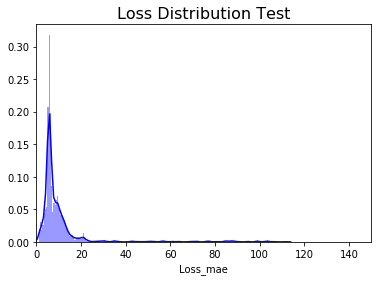

In [0]:
scored = pd.DataFrame()
scored['Loss_mae'] = mses_test
plt.figure()
plt.title('Loss Distribution Test', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 200, kde= True, color = 'blue');
plt.xlim([0.0,150])

## Set a thershold for the validation error so that we don't risk anything. The Autoencoder must only get rid of easy examples.

In [0]:
THRESHOLD = 20
y_pred_valid = np.array(mses_valid) >= THRESHOLD

y_preds = []
for yp in y_pred_valid:
  if yp == True:
    y_preds.append(1)
  else:
    y_preds.append(0)

print("Detected anomalies: ", np.sum(y_pred_valid == 1))

Detected anomalies:  261


## Write to disk the anomalies caught by the autoencoder

In [0]:
_write_output_file(y_preds, "anomalies_caught_by_autoencoder.csv")

## Detecting anomalies in the test set using the AE

In [0]:
THRESHOLD = 25
y_pred_test = np.array(mses_test) >= THRESHOLD

y_preds = []
for yp in y_pred_test:
  if yp == True:
    y_preds.append(1)
  else:
    y_preds.append(0)

print("Detected anomalies: ", np.sum(y_pred_test == 1))

_write_output_file(y_preds, "y_test_ae.csv")

Detected anomalies:  84


## Optional: Visualize some signals

5.178517486899193


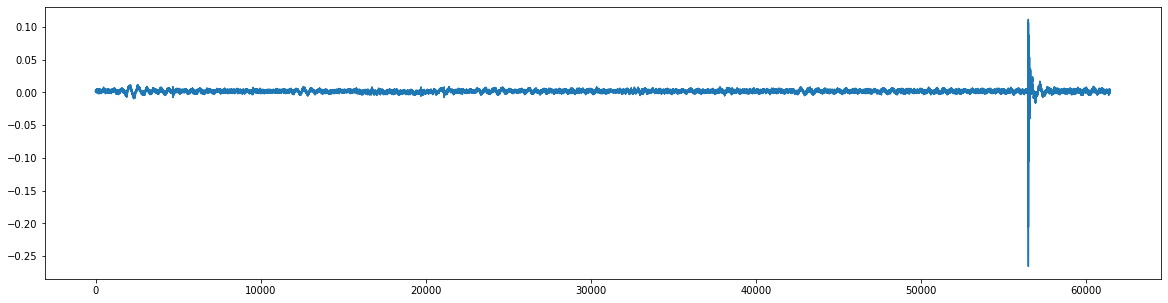

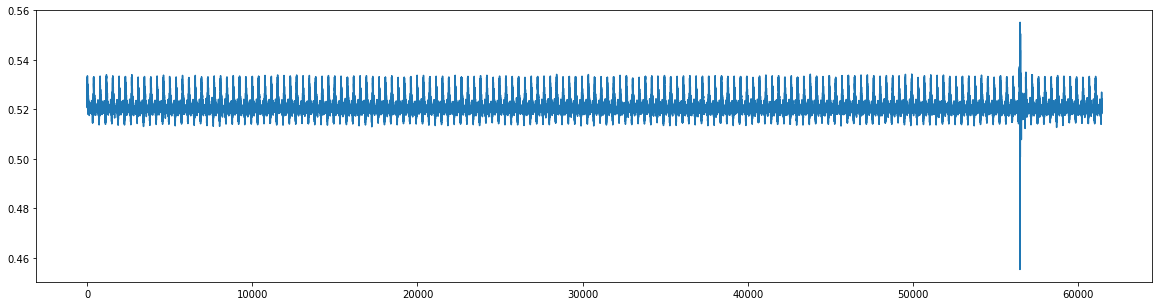

In [0]:
sample = 1822

print(mses_test[sample])

plot_sequence(X_test[sample])

xx = X_test_list[sample]
pred = autoencoder.predict(xx).reshape(xx.shape[0]*xx.shape[1], )
plot_sequence(pred)


# Part 2: Difficult anomalies detection using metric learning

### Auxiliary functions

In [0]:
from collections import Counter

def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics
  
def get_features_ab(ecg_data, waveletname):
    list_features = []
    for signal in ecg_data:
        list_coeff = pywt.wavedec(signal, waveletname)
        features = []
        for coeff in list_coeff:
            features += get_features(coeff)
        list_features.append(features)
    return list_features

def dbscan_predict(model, X):

    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

def plot2D_with_plotly(X_embedded_valid, labels, title="", name_ones="Anomalies", name_zeros="Normal"):
    fig = go.Figure()

    df = pd.DataFrame(np.c_[range(X_embedded_valid.shape[0]), X_embedded_valid], columns=['index', 'PC1', 'PC2'])

    
    normals = df[labels == 0]
    anomalies = df[labels == 1]

    fig.add_trace(go.Scatter(x = normals.iloc[:,1],
                         y = normals.iloc[:,2],
                         marker=dict(size = 6, color = "red"),
                         mode="markers",
                         name = name_zeros,
                         hovertext=[str(i) for i in normals['index']]))

    fig.add_trace(go.Scatter(x = anomalies.iloc[:,1],
                         y = anomalies.iloc[:,2],
                         marker=dict(size = 6, color = "blue"),
                         mode="markers",
                         name = name_ones,
                         hovertext=[str(i) for i in anomalies['index']]))

    fig.update_layout(title=title,
                      showlegend=True)
    fig.show()
    
def plot2D_with_plotly_with3(X_embedded_valid, labels, title="", name_ones="Anomalies", name_zeros="Normal", name_tests_ones="Test Anomalies", name_tests_zeros="Test Normals"):
  fig = go.Figure()

  df = pd.DataFrame(np.c_[range(X_embedded_valid.shape[0]), X_embedded_valid], columns=['index', 'PC1', 'PC2'])


  normals = df[labels == 0]
  anomalies = df[labels == 1]
  testing_normals = df[labels == 2]
  testing_anomalies = df[labels == 3]

  fig.add_trace(go.Scatter(x = normals.iloc[:,1],
                       y = normals.iloc[:,2],
                       marker=dict(size = 6, color = "red"),
                       mode="markers",
                       name = name_zeros,
                       hovertext=[str(i) for i in normals['index']]))

  fig.add_trace(go.Scatter(x = anomalies.iloc[:,1],
                       y = anomalies.iloc[:,2],
                       marker=dict(size = 6, color = "blue"),
                       mode="markers",
                       name = name_ones,
                       hovertext=[str(i) for i in anomalies['index']]))

  fig.add_trace(go.Scatter(x = testing_anomalies.iloc[:,1],
                       y = testing_anomalies.iloc[:,2],
                       marker=dict(size = 6, color = "green"),
                       mode="markers",
                       name = name_tests_ones,
                       hovertext=[str(i) for i in testing_anomalies['index']]))
  
  fig.add_trace(go.Scatter(x = testing_normals.iloc[:,1],
                     y = testing_normals.iloc[:,2],
                     marker=dict(size = 6, color = "orange"),
                     mode="markers",
                     name = name_tests_zeros,
                     hovertext=[str(i) for i in testing_normals['index']]))

  fig.update_layout(title=title,
                    showlegend=True)
  fig.show()

def compare_with_best(current, best):
    index_of_anomalies_in_best = np.where(best==1)
    index_of_anomalies_in_current = np.where(current==1)
    l = len(np.intersect1d(index_of_anomalies_in_best, index_of_anomalies_in_current))
    print("Anomalies", l,"/", len(index_of_anomalies_in_best[0]))
        
    print("Precision:", l/len(index_of_anomalies_in_current[0]))
    print("Recall:", l/len(index_of_anomalies_in_best[0]))

In [0]:
print(pywt.wavelist(kind='discrete'))

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


In [0]:
true_labels = pd.read_csv("./all_labels.csv", delimiter=",")
true_labels = np.array(true_labels['anomaly'])

labels_dbscan = pd.read_csv("./y_test_dbscan.csv", delimiter=";")
labels_dbscan = np.array(labels_dbscan['anomaly'])

labels_oneclass = pd.read_csv("./y_test_compiled.csv", delimiter=";")
labels_oneclass = np.array(labels_oneclass['anomaly_one_class'])

labels_majvote = pd.read_csv("./y_test_compiled.csv", delimiter=";")
labels_majvote = np.array(labels_majvote['majority_voting'])

labels_isolation = pd.read_csv("./y_test_compiled.csv", delimiter=";")
labels_isolation = np.array(labels_isolation['anomaly_isolation'])


### Extracting DWT Features

In [0]:
X_train_agg, X_valid_agg, X_test_agg = aggregate_by_mean(X_train, X_validation, X_test)

print(X_train_agg.shape)
print(X_valid_agg.shape)
print(X_test_agg.shape)

(1677, 12288)
(594, 12288)
(1917, 12288)


In [0]:
x_t = np.array(get_features_ab(X_train_agg, 'bior6.8'))
x_v = np.array(get_features_ab(X_valid_agg, 'bior6.8'))
x_tst = np.array(get_features_ab(X_test_agg, 'bior6.8'))

In [0]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_t)
x_valid_scaled = scaler.transform(x_v)
x_test_scaled = scaler.transform(x_tst)


### Different t-SNE Visualizations

In [0]:
X_embedded_train = TSNE(n_components=2).fit_transform(x_train_scaled)
X_embedded_valid = TSNE(n_components=2).fit_transform(x_valid_scaled)
X_embedded_test = TSNE(n_components=2).fit_transform(x_test_scaled)

In [0]:
plot2D_with_plotly(X_embedded_train, np.zeros(X_embedded_train.shape[0]), "Train data - All Normals")

In [0]:
plot2D_with_plotly(X_embedded_valid, labels_after_ae, "Validation data with AutoEncoder anomalies")
compare_with_best(labels_after_ae, true_labels)

In [0]:
plot2D_with_plotly(X_embedded_valid, true_labels, "Validation data with True Labels")

In [0]:
plot2D_with_plotly(X_embedded_test, labels_oneclass, "Test data - OC-SVM Labels")

In [0]:
x_train_test = np.concatenate((x_train_scaled, x_test_scaled), axis=0)
y_train_test = np.concatenate((np.ones(x_train_scaled.shape[0]), np.zeros(x_test_scaled.shape[0])), axis=0)

X_embedded_train_test = TSNE(n_components=2).fit_transform(x_train_test)

plot2D_with_plotly(X_embedded_train_test, y_train_test, "Train + Test Data", "Train", "Test")

In [0]:
x_train_valid = np.concatenate((x_train_scaled, x_valid_scaled), axis=0)
y_train_valid = np.concatenate((np.ones(x_train_scaled.shape[0]), np.zeros(x_valid_scaled.shape[0])), axis=0)

X_embedded_train_valid = TSNE(n_components=2).fit_transform(x_train_valid)

plot2D_with_plotly(X_embedded_train_valid, y_train_valid, "Train + Valid Data", "Train Pts", "Valid Pts")

In [0]:
x_valid_test = np.concatenate((x_valid_scaled, x_test_scaled), axis=0)
y_valid_test = np.concatenate((true_labels, 2+labels_oneclass), axis=0)

X_embedded_valid_test = TSNE(n_components=2).fit_transform(x_valid_test)

plot2D_with_plotly_with3(X_embedded_valid_test, y_valid_test, "Valid + Test Data")

## Computing Mean and S-Dev distribution on Validation and Test

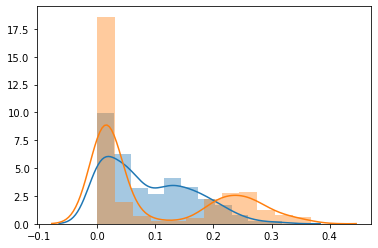

In [0]:
means_validation = np.mean(X_validation, axis=1)
means_test = np.mean(X_test, axis=1)

sdev_validation = np.std(X_validation, axis=1)
sdev_test = np.std(X_test, axis=1)

sns.distplot(sdev_validation)
sns.distplot(sdev_test)
# plt.savefig("sdevs.png", dpi=200)

## Domain Adaptation from Validation to Test

In [0]:
from scipy.spatial.distance import cdist
import ot

def entropic_reg_ot(S, T, reg_e=0.01):
    ns = S.shape[0]
    nt = T.shape[0]
    
    a = (1/ns) * np.ones(ns)
    b = (1/nt) * np.ones(nt)
    
    M = cdist(S, T)
    M = M / np.max(M)
    
    G = ot.sinkhorn(a, b, M, reg_e)
    
    S_a = G @ T
    
    return S_a
  


In [0]:
SSa = entropic_reg_ot(x_train_valid, x_test_scaled, 5)

In [0]:
X_embedded_ssa = TSNE(n_components=2).fit_transform(SSa)
plot2D_with_plotly(X_embedded_ssa, true_labels)

In [0]:
x_ssa_test = np.concatenate((SSa, x_test_scaled), axis=0)
y_ssa_test = np.concatenate( (np.concatenate((np.zeros(X_train.shape[0]), true_labels)), 2+labels_oneclass), axis=0)

X_embedded_ssa_test = TSNE(n_components=2).fit_transform(x_ssa_test)

In [0]:
plot2D_with_plotly_with3(X_embedded_ssa_test, y_ssa_test, "Valid + Test Data")

### Optimal Transport and Domain Adaptation

In [0]:
import ot

In [0]:
scaler = StandardScaler()

x_valid_scaled = scaler.fit_transform(x_v)
x_test_scaled = scaler.transform(x_tst)

In [0]:
ot_lpl1 = ot.da.SinkhornL1l2Transport(reg_e=1, reg_cl=0.01, max_iter=40,
                                      verbose=False)
ot_lpl1.fit(Xs=x_valid_scaled, ys=true_labels, Xt=x_test_scaled)

/usr/local/lib/python3.6/dist-packages/ot/bregman.py:359: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/ot/bregman.py:359: RuntimeWarning:

overflow encountered in true_divide



In [0]:
transp_Xs_lpl1 = ot_lpl1.transform(Xs=x_valid_scaled)

In [0]:
transp_Xs_lpl1.shape

(594, 120)

In [0]:
x_ssa_test = np.concatenate((transp_Xs_lpl1, x_test_scaled), axis=0)
y_ssa_test = np.concatenate((true_labels, 2+labels_oneclass), axis=0)

X_embedded_ssa_test = TSNE(n_components=2).fit_transform(x_ssa_test)

In [0]:
plot2D_with_plotly_with3(X_embedded_ssa_test, y_ssa_test, "Valid + Test Data")

In [0]:
plot2D_with_plotly_with3(X_embedded_ssa_test, y_ssa_test, "Valid + Test Data")

In [0]:
plot2D_with_plotly_with3(X_embedded_ssa_test, y_ssa_test, "Valid + Test Data")

## Metric Learning Part - (Steps: apply K-PCA to catch non-linearities, apply LMNN to obtain a new representation, apply DBSCAN to build a ball used at testing time)

### Plotting the k-PCA representation of the remaining points after removing the ae-anomalies

In [0]:
for i in range(X_embedded_test.shape[0]):
  if (X_embedded_test[i,0] <= 0 and X_embedded_test[i,1] <= 0):
    labels_ae_test[i] = 1

In [0]:
x_valid_left = x_valid_scaled[labels_after_ae == 0]
labels_valid_left = true_labels[labels_after_ae == 0]

pca = KernelPCA(n_components=120, kernel='rbf', gamma=0.1)
principalComponentsValid = pca.fit_transform(x_valid_left)

# plot2D_with_plotly(principalComponentsValid[:,0:2], labels_valid_left, "After Kernel PCA (With True Labels)")

In [0]:
x_test_left = x_test_scaled[labels_ae_test == 0]
labels_test_left = labels_manually_agree[labels_ae_test == 0]


pca = KernelPCA(n_components=120, kernel='rbf', gamma=0.1)
principalComponentsTest = pca.fit_transform(x_test_left)

plot2D_with_plotly(principalComponentsTest[:,0:2], labels_test_left, "Test points After Kernel PCA")

## Fit the LMNN  (Metric Learning algorithm)

In [0]:
lmnn = LMNN(k=5, learn_rate=1e-6, regularization=0.9)
rez = lmnn.fit_transform(principalComponentsTest, labels_manually_agree[labels_ae_test==0])

/usr/local/lib/python3.6/dist-packages/metric_learn/lmnn.py:207: ChangedBehaviorWarning:

Warning, no init was set (`init=None`). As of version 0.5.0, the default init will now be set to 'auto', instead of the previous identity matrix. If you still want to use the identity matrix as before, set init='identity'. This warning will disappear in v0.6.0, and `init` parameter's default value will be set to 'auto'.



In [0]:
plot2D_with_plotly(rez[:,0:2], labels_valid_left, "After Metric Learning (With true labels)")

In [0]:
rez_test = lmnn.transform(principalComponentsTest)
plot2D_with_plotly(rez_test[:,0:2], np.ones(rez_test.shape[0]), "Test After Metric Learning")

## Learn a ball around the normal examples with DBSCAN

In [0]:
dbscan = DBSCAN(eps=0.5, min_samples=5, metric=lmnn.get_metric())
dbscan.fit(rez)

dbscan_anomalies = dbscan_predict(dbscan, rez)
dbscan_anomalies[dbscan_anomalies != -1] = 0
dbscan_anomalies[dbscan_anomalies == -1] = 1

        
plot2D_with_plotly(rez[:,0:2], dbscan_anomalies, "Labels Predicted by DBSCAN")

In [0]:
dbscan_test = dbscan_predict(dbscan, rez_test)
dbscan_test[dbscan_test != -1] = 0
dbscan_test[dbscan_test == -1] = 1

        
plot2D_with_plotly(rez_test[:,0:2], dbscan_test, "Test - Labels Predicted by DBSCAN")

In [0]:
labels_test_all = np.copy(labels_ae_test)
labels_test_all[np.where(labels_test_all==0)] = dbscan_test

In [0]:
plot2D_with_plotly(X_embedded_test, labels_test_all, "")

In [0]:
np.sum(labels_ae_test == 1)

86

## Merging ae-anomalies with dbscan-anomalies

In [0]:
labels_after_ae[np.where(labels_after_ae==0)] = dbscan_anomalies

In [0]:
plot2D_with_plotly(X_embedded_valid, labels_after_ae, "")
compare_with_best(labels_after_ae, true_labels)

In [0]:
_write_output_file(labels_after_ae.tolist(), "anomalies_to_submit.csv")

## Manually annotated test data

In [0]:
labels_ae_test = pd.read_csv("./y_test_ae.csv", delimiter=";")
labels_ae_test = np.array(labels_ae_test['anomaly'])

plot2D_with_plotly_with3(X_embedded_test, labels_ae_test, "Autoencoder")

In [0]:
labels_manually_agree = pd.read_csv("./merge_results2.csv", delimiter=";")
labels_manually_agree = np.array(labels_manually_agree['anomaly'])

plot2D_with_plotly_with3(X_embedded_test, labels_manually_agree, "Manually annotated Agreement")

In [0]:
plot2D_with_plotly(X_embedded_test, labels_test_all, "")

In [0]:
labels_manually_3 = pd.read_csv("./expert_scores_Louise.csv", delimiter=";")
labels_manually_3 = np.array(labels_manually_3['anomaly'])

plot2D_with_plotly_with3(X_embedded_test, labels_manually_3, "Manually annotated Louise")

In [0]:
plot2D_with_plotly(X_embedded_test, labels_isolation, "Test data - OC-SVM Labels")

In [0]:
labels_manually_2 = pd.read_csv("./MLDMproj.csv", delimiter=";")
labels_manually_2 = np.array(labels_manually_2['anomaly'])

In [0]:
plot2D_with_plotly_with3(X_embedded_test, labels_manually_2, "Man0ually annotated")

In [0]:
labels_manually = pd.read_csv("./manually_annotated_test.csv", delimiter=";")
labels_manually = np.array(labels_manually['anomaly'])

In [0]:
plot2D_with_plotly_with3(X_embedded_test, labels_manually, "Manually annotated")

In [0]:
labels_ae_test = pd.read_csv("./y_test_ae.csv", delimiter=";")
labels_ae_test = np.array(labels_ae_test['anomaly'])

plot2D_with_plotly(X_embedded_test, labels_ae_test , "Test data - AE Labels")